## Results of the models

In this notebook we will compare the results of the notebooks of the different models to wee which is better

In [99]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cosine_similarity
import pandas as pd
import numpy as np
from skipgram import *

In [100]:
logs_df = pd.read_csv('../data/sitges_access_prepared_last.csv')

In [101]:
# Dataset to work without sequences
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.values.astype(np.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return torch.tensor(sample)


# Custom Dataset class to create sequences on-the-fly
class SequenceDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length + 1

    def __getitem__(self, idx):
        sequence = self.data[idx:idx + self.seq_length].to_numpy()
        return torch.tensor(sequence, dtype=torch.float32)

In [102]:

test_dataset_normalAutoencoder = CustomDataset(logs_df)
test_loader_normalAutoencoder = DataLoader(test_dataset_normalAutoencoder, batch_size=1, shuffle=False)

test_dataset_LSTMAutoencoder = SequenceDataset(logs_df, 20)
test_loader_LSTMAutoencoder = DataLoader(test_dataset_LSTMAutoencoder, batch_size=1, shuffle=False)

In [103]:
class LogAnomalyDetector(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LogAnomalyDetector, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2])
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size[2], hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], input_size)
        )

    def forward(self, x):
        emb = self.encoder(x)
        #print("Latent space:", emb)
        x = self.decoder(emb)
        return x

In [104]:
class LSTMAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        # Encoder
        _, (hidden, _) = self.encoder(x)
        # Repeat the last hidden state seq_len times
        hidden = hidden[-1].repeat(seq_len, 1, 1).transpose(0, 1)
        # Decoder
        decoded, _ = self.decoder(hidden)
        return decoded

In [105]:
input_size=len(logs_df.columns)
hidden_size=[50, 20, 5] 
num_layers=1
normalAutoencoder = LogAnomalyDetector(input_size=input_size, hidden_size=hidden_size)

input_dim = len(logs_df.columns)  # Number of features in your log data
hidden_dim = input_dim//4
num_layers = 3
LSTMAutoencoder = LSTMAutoencoder(input_dim, hidden_dim, num_layers)

In [106]:
ROOT_DIR = os.path.dirname(os.path.abspath(""))
normalAutoencoder.load_state_dict(torch.load(os.path.join(ROOT_DIR, "models/normalAutoencoder.pt"), map_location=torch.device('cpu')))
LSTMAutoencoder.load_state_dict(torch.load(os.path.join(ROOT_DIR, "models/LSTMAutoencoder.pt"), map_location=torch.device('cpu')))

<All keys matched successfully>

In [107]:
def get_all_losses(model, test_loader, criterion):
    
    model.eval() 
    possible_anomalies=[]
    total_losses=[]

    with torch.no_grad():
        for i, input in enumerate(test_loader):
            #inputs = inputs.to(device)
            output = model(input)
            loss = criterion(output.squeeze(), input.squeeze())
            possible_anomalies.append(i)
            total_losses.append(loss)
            
    return possible_anomalies, total_losses


In [108]:
def select_possible_anomalies(possible_anomalies, scores, threshold):

    anomalies=[]
    for log, score in zip(possible_anomalies, scores):
        if score >= threshold: anomalies.append((log, score))

    return anomalies

In [109]:
def plot_total_losses(total_losses):
    # Calculate scores by normalizing losses to the range [0, 1]
    min_loss = min(total_losses)
    max_loss = max(total_losses)
    
    # Avoid division by zero in case all losses are the same
    if max_loss == min_loss:
        scores = [0.5] * len(total_losses)  # Arbitrary score if all losses are the same
    else:
        scores = [((loss - min_loss) / (max_loss - min_loss)) for loss in total_losses]


    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.scatter(total_losses, scores, label='Loss vs. Score', alpha=0.6)
    plt.xlabel('Loss')
    plt.ylabel('Score')
    plt.title('Loss vs. Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    return scores

In [110]:
criterion = nn.MSELoss()
possible_anomalies_normalAutoencoder, total_losses_normalAutoencoder=get_all_losses(normalAutoencoder, test_dataset_normalAutoencoder, criterion)

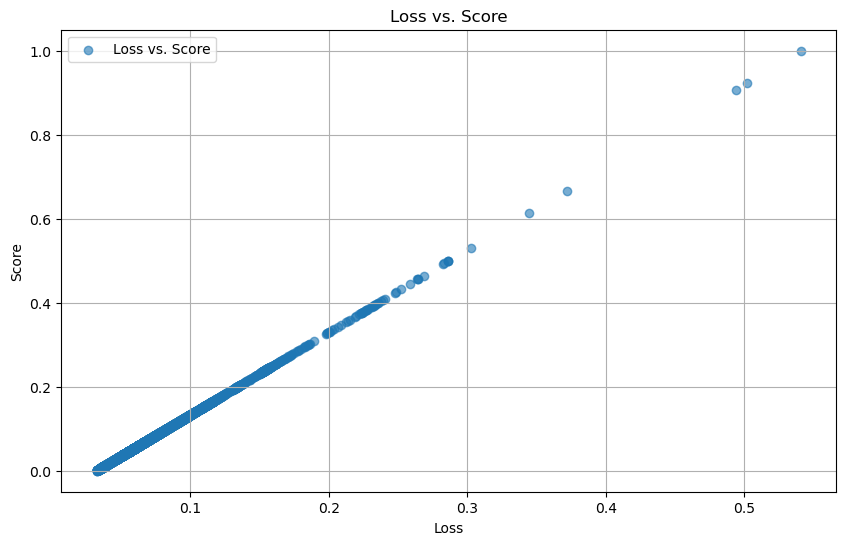

In [111]:
scores_normalAutoencoder=plot_total_losses(total_losses_normalAutoencoder)

In [112]:
threshold=0.5
final_possible_anomalies_normalAutoencoder=select_possible_anomalies(possible_anomalies_normalAutoencoder, scores_normalAutoencoder, threshold)

In [113]:
print(len(final_possible_anomalies_normalAutoencoder))

6


In [114]:
criterion = nn.MSELoss()
possible_anomalies_LSTMAutoencoder, total_losses_LSTMAutoencoder=get_all_losses(LSTMAutoencoder, test_loader_LSTMAutoencoder, criterion)

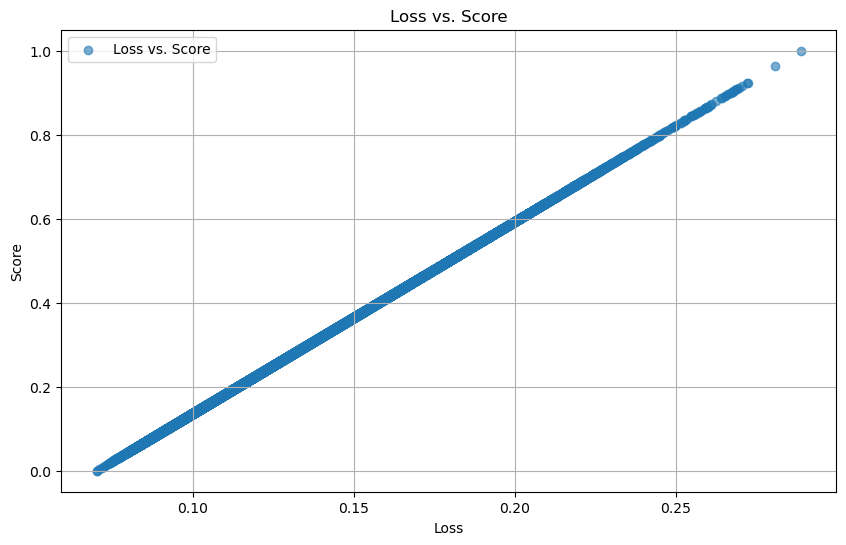

In [115]:
scores_LSTMAutoencoder=plot_total_losses(total_losses_LSTMAutoencoder)

In [116]:
threshold=0.8
final_possible_anomalies_LSTMAutoencoder=select_possible_anomalies(possible_anomalies_LSTMAutoencoder, scores_LSTMAutoencoder, threshold)

In [117]:
print(len(final_possible_anomalies_LSTMAutoencoder))

61


In [118]:
real_logs_df = pd.read_csv('../data/sitges_access.20240129.csv')


In [119]:
def vec2log(anomalies, dataframe, seq):
    logs=[]
    if seq:
        for i, anomaly in enumerate(anomalies):
            sequence = dataframe.iloc[anomaly[0]:anomaly[0]+20].copy()
            # Add a 'Sequence' column with the sequence number
            sequence['sequence'] = i
            score = round(anomaly[1].item(), 2)
            sequence['score'] = str(score)
            logs.append(sequence)
    else:
        for anomaly in anomalies:
            log = dataframe.iloc[[anomaly[0]]].copy()
            # Add a 'Sequence' column with the sequence number
            score = round(anomaly[1].item(), 2)
            log['score'] = str(score)
            logs.append(log)

    if logs:  # Ensure there are logs to concatenate
        df_logs = pd.concat(logs, ignore_index=True)
    else:
        df_logs = pd.DataFrame(columns=dataframe.columns)  # Handle case with no anomalies

    return df_logs

In [120]:
logs_normalAutoencoder=vec2log(final_possible_anomalies_normalAutoencoder, real_logs_df, False)
logs_normalAutoencoder.sort_values(by='score', ascending=True)

,Unnamed: 0,server_name,IP,logname,authenticate,date,petition,URL,status,bytes,referer,user-agent,score
5,45754,www.sitgesanytime.com,195.154.122.36,-,-,2024-01-29 09:51:00+01:00,GET,/plantilles/turisme/css/estils-print.css?v=3 H...,200,655,https://www.sitgesanytime.com/ca/pl82/planific...,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,0.53
3,35852,www.sitgesanytime.com,168.119.65.108,-,-,2024-01-29 07:58:44+01:00,GET,/plantilles/turisme/eltemps/eltemps.js HTTP/2.0,200,1751,https://www.sitgesanytime.com/fr/pl355/explore...,Mozilla/5.0 (compatible; AhrefsBot/7.0; +http:...,0.61
2,14979,www.sitgesanytime.com,217.113.194.124,-,-,2024-01-29 03:30:16+01:00,GET,/en/pl7/what-to-do/places-of-interest/id432/mo...,200,10967,-,Mozilla/5.0 (compatible; Barkrowler/0.9; +http...,0.67
0,197,www.sitgesanytime.com,5.59.171.195,-,-,2024-01-29 00:03:02+01:00,GET,/plantilles/turisme/img/logo-cat-viles-mariner...,200,9483,https://www.sitgesanytime.com/es/pl415/blog/ll...,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0.91
4,43535,www.sitgesanytime.com,111.225.149.172,-,-,2024-01-29 09:37:39+01:00,GET,/media/site1/cache/images/mgl9194-redim-prop-e...,200,10914,https://www.sitgesanytime.com/en/plan-your-tri...,Mozilla/5.0 (Linux; Android 5.0) AppleWebKit/5...,0.92
1,8419,www.sitgesanytime.com,110.249.201.180,-,-,2024-01-29 02:29:10+01:00,GET,/plantilles/turisme/img/ico-search.svg HTTP/2.0,200,583,https://www.sitgesanytime.com/en/,Mozilla/5.0 (Linux; Android 5.0) AppleWebKit/5...,1.0


In [121]:
logs_LSTMAutoencoder=vec2log(final_possible_anomalies_LSTMAutoencoder, real_logs_df, True)
logs_LSTMAutoencoder

,Unnamed: 0,server_name,IP,logname,authenticate,date,petition,URL,status,bytes,referer,user-agent,sequence,score
0,2091,www.sitgesanytime.com,31.221.168.138,-,-,2024-01-29 00:37:48+01:00,GET,/media/site1/cache/images/twitter-logo-x2.png ...,200,1460,https://www.sitgesanytime.com/es/pl330/actuali...,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0,0.82
1,2092,www.sitgesanytime.com,31.221.168.138,-,-,2024-01-29 00:37:48+01:00,GET,/media/site1/cache/images/pinterest-blanco.png...,200,896,https://www.sitgesanytime.com/es/pl330/actuali...,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0,0.82
2,2093,www.sitgesanytime.com,31.221.168.138,-,-,2024-01-29 00:37:48+01:00,GET,/plantilles/turisme/img/logo-peu.png HTTP/2.0,200,5547,https://www.sitgesanytime.com/es/pl330/actuali...,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0,0.82
3,2094,www.sitgesanytime.com,31.221.168.138,-,-,2024-01-29 00:37:48+01:00,GET,/plantilles/turisme/img/ico-globe.svg HTTP/2.0,200,410,https://www.sitgesanytime.com/plantilles/turis...,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0,0.82
4,2095,www.sitgesanytime.com,31.221.168.138,-,-,2024-01-29 00:37:48+01:00,GET,/plantilles/turisme/img/ico-menu.gif HTTP/2.0,200,1365,https://www.sitgesanytime.com/plantilles/turis...,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,0,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215,54928,www.sitgesanytime.com,158.181.70.153,-,-,2024-01-29 10:59:50+01:00,GET,/plantilles/turisme/eltemps/wstemps.php?site=1...,200,477,https://www.sitgesanytime.com/en/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,60,0.84
1216,54929,www.sitgesanytime.com,158.181.70.153,-,-,2024-01-29 10:59:50+01:00,GET,/plantilles/turisme/img/ico-play.svg HTTP/2.0,200,1081,https://www.sitgesanytime.com/plantilles/turis...,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,60,0.84
1217,54930,www.sitgesanytime.com,158.181.70.153,-,-,2024-01-29 10:59:50+01:00,POST,/en//cal_dades_dies HTTP/2.0,200,224,https://www.sitgesanytime.com/en/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,60,0.84
1218,54931,www.sitgesanytime.com,158.181.70.153,-,-,2024-01-29 10:59:50+01:00,GET,/plantilles/turisme/img/temps3/31.svg HTTP/2.0,200,4813,https://www.sitgesanytime.com/en/,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; ...,60,0.84
